In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numba

# Binary Images

Suppose I have a black and white image where each pixel value corresponds to the brightness intensity:

In [2]:
image = Image.open(r"C:\Users\lukep\Videos\comedy_misc\stack_lowres.PNG")

In [4]:
data = np.array(image).astype(np.float32) / 255.

In [46]:
# Open the image form working directory
path = r"C:\Users\lukep\Videos\dithering\giraffe.jpg"
#path = r"C:\Users\lukep\Videos\comedy_misc\stack_lowres.PNG"
image = Image.open(path)
data = np.array(image).astype(np.float32) / 255.
if len(data.shape)==2:
    data = data[:,:,np.newaxis]

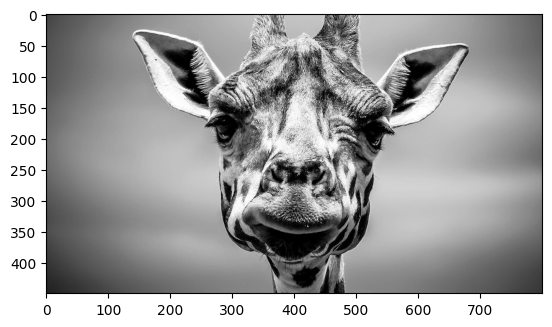

In [47]:
plt.imshow(data[:,:,0], cmap='Greys_r')

Now suppose I need to display this image on a display device, such as a monitor, but the monitor contains LEDs that are either on (full brightness) or off.
* One way to display the image would be to round each pixel value to the nearest extreme (either full bright, or completely off)

In [48]:
data_rounded = np.round(data)

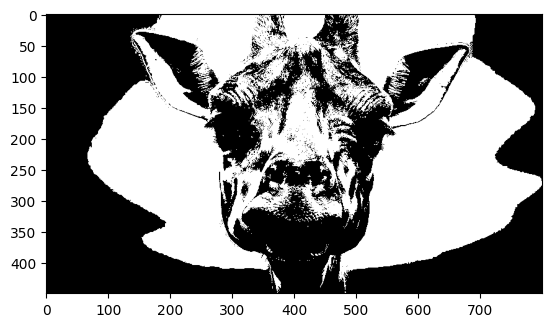

In [49]:
plt.imshow(data_rounded[:,:,0], cmap='Greys_r')

This tends to increase contrast significantly, however.

# Dithering Algorithms

Each time a pixel $(i,j)$ in the image $I_{acc}$ is rounded, it accumulates an error $e$ given by

$$e = I_{acc}(i,j) - I_{out}(i,j)$$

where $I_{out}$ is the rounded image. This error quantifies the extent to which

* new pixel is either too bright ($e<0$)
* new pixel is too dark ($e>0$)

The idea behind dithering algorithms is too diffuse this error accross neighbouring pixels.

* https://research.cs.wisc.edu/graphics/Courses/559-s2004/docs/floyd-steinberg.pdf

In [15]:
data.shape

(280, 300, 1)

# Floyd-Steinberg

In [16]:
@numba.jit("f4[:,:,:](f4[:,:,:])", nopython=True, nogil=True)
def floyd_steinberg(image):
    Lx, Ly, Lc = image.shape
    for j in range(Ly):
        for i in range(Lx):
            for c in range(Lc):
                rounded = round(image[i,j,c])
                err = image[i,j,c] - rounded
                image[i,j,c] = rounded
                if i<Lx-1: image[i+1,j,c] += (7/16)*err
                if j<Ly-1:
                    image[i,j+1,c] += (5/16)*err
                    if i>0: image[i-1,j+1,c] += (1/16)*err
                    if i<Lx-1: image[i+1,j+1,c] += (3/16)*err           
    return image

In [17]:
data_fs = floyd_steinberg(data.copy())

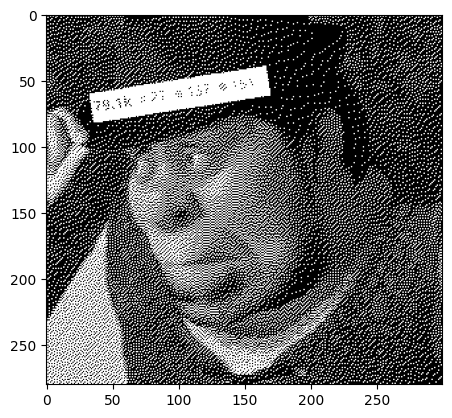

In [18]:
plt.imshow(data_fs[:,:,0], cmap='Greys_r')

# Atkinson Dithering

A summary of the Atkinson Dithering Algorithm can be found here

* https://beyondloom.com/blog/dither.html

In [37]:
@numba.jit("f4[:,:,:](f4[:,:,:])", nopython=True, nogil=True)
def atkinson(image):
    frac = 8
    Lx, Ly, Lc = image.shape
    for j in range(Ly):
        for i in range(Lx):
            for c in range(Lc):
                rounded = round(image[i,j,c])
                err = image[i,j,c] - rounded
                image[i,j,c] = rounded
                if i<Lx-1: image[i+1,j,c] += err / frac
                if i<Lx-2: image[i+2,j,c] += err /frac
                if j<Ly-1:
                    image[i,j+1,c] += err / frac
                    if i>0: image[i-1,j+1,c] += err / frac
                    if i<Lx-1: image[i+1,j+1,c] += err / frac
                if j<Ly-2: image[i,j+2,c] += err / frac      
    return image

In [32]:
data_atk = atkinson(data.copy())

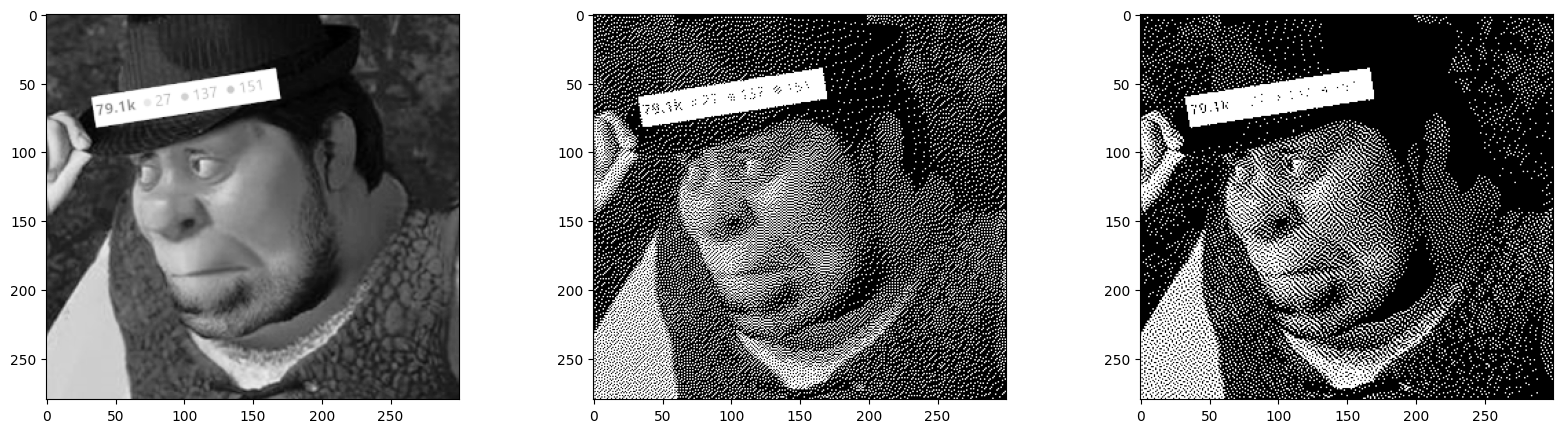

In [30]:
plt.subplots(1,3,figsize=(20,5))
plt.subplot(131)
plt.imshow(data, cmap='Greys_r')
plt.subplot(132)
plt.imshow(data_fs, cmap='Greys_r')
plt.subplot(133)
plt.imshow(data_atk, cmap='Greys_r')

# Larger Color Image

In [34]:
# Open the image form working directory
image = Image.open('../Data/highres.jpg')
data = np.array(image).astype(np.float32) / 255.
data_fs = floyd_steinberg(data.copy())
data_atk = atkinson(data.copy())

Looking at the full image, there is little noticable difference due to the small size of the voxels. Note that Atkinson tends to increase contrast.

Text(0.5, 1.0, 'Atkinson')

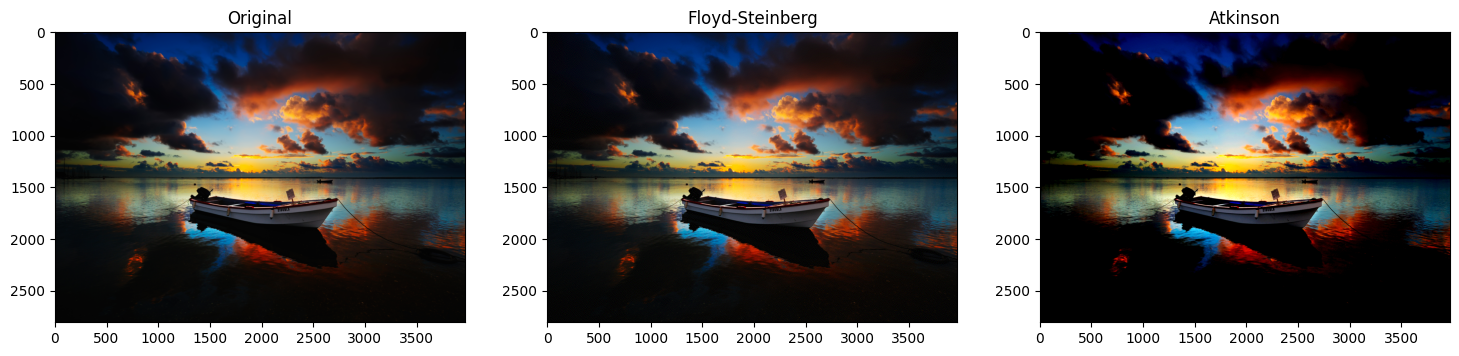

In [35]:
plt.subplots(1,3,figsize=(18,6))
plt.subplot(131)
plt.imshow(data)
plt.title('Original')
plt.subplot(132)
plt.imshow(data_fs)
plt.title('Floyd-Steinberg')
plt.subplot(133)
plt.imshow(data_atk)
plt.title('Atkinson')

Zooming in, we can see the differences:

Text(0.5, 1.0, 'Atkinson')

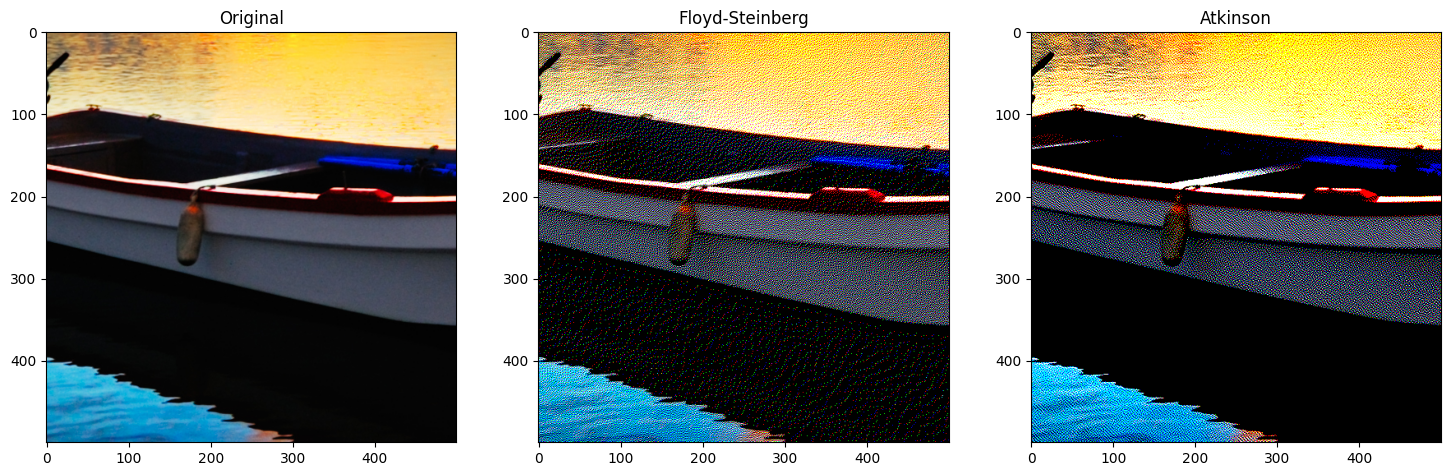

In [36]:
plt.subplots(1,3,figsize=(18,6))
plt.subplot(131)
plt.imshow(data[1500:2000,1500:2000])
plt.title('Original')
plt.subplot(132)
plt.imshow(data_fs[1500:2000,1500:2000])
plt.title('Floyd-Steinberg')
plt.subplot(133)
plt.imshow(data_atk[1500:2000,1500:2000])
plt.title('Atkinson')